In [1]:
import numpy as np
import pandas as pd
import os
import itertools
from typing import List, Tuple
import string
from pathlib import Path
from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Load the e coli sequences

In [5]:
inputs_dir = "/projects/robustmicrob/jlaw/inputs/jarboe_data"
df_all = pd.read_csv(f"{inputs_dir}/20230228/master_T_data_rebuilt_TPP_ALE_analysis.csv", 
                     header=[1])
print(len(df_all))
df_all.head(2)

4384


,Accession 1,Gene Name,UNIPROT,Accession 2,All Names Concat,Left End Position,Right End Position,Centisome Position,Direction,Length (bp),...,R2 4,Tm 5 (Arctic Express),R2 5,Chaperone Interaction Protein (Protein Homeostatis Database),composite sensitivity (TPP-ALE-CIP),ProTstab2 Tm,combined Tm,normalized points,sources,sequence difference in MG1655 from W3110 (increased thermotolerance)
0,b4154,frdA,P00363,ECK4150,frdA // b4154 // ECK4150 // EG10330 // ABE-001...,4380510,4382318,94.373940,<-,1809,...,0.8,44.62,0.9,+,+,50.08,56.0,0.4,proteome only,WT
1,b1109,ndh,P00393,ECK1095,ndh // b1109 // ECK1095 // EG10649 // ABE-0003746,1166085,1167389,25.122198,->,1305,...,1,43.48,0.96,+,+,46.32,51.4,0.4,proteome only,WT


In [48]:
df_all["EC number"].dropna()

Accession 1
b1109    1.6.5.9; 1.16.1.-
b0002     2.7.2.4; 1.1.1.3
b3940     2.7.2.4; 1.1.1.3
b3863              2.7.7.7
b0215              2.7.7.7
               ...        
b3011              1.1.1.-
b3022              3.1.-.-
b2269             3.4.22.-
b0225              3.1.-.-
b4477             4.1.2.21
Name: EC number, Length: 1005, dtype: object

In [6]:
bnum_to_uniprot = dict(zip(df_all["Accession 1"], df_all["UNIPROT"]))
uniprot_to_bnum = dict(zip(df_all["UNIPROT"], df_all["Accession 1"]))

In [7]:
# duplicate_locus_ids = ['b4607', 'b4416', 'b4164', 'b1910', 'b4442', 'b4556', 'b4524', 'b2856']
# df_all = df_all[~df_all['Accession 1'].isin(duplicate_locus_ids)]
# df_all = df_all.set_index('UNIPROT')
# print(len(df_all))

In [8]:
df_all = df_all.set_index("Accession 1")

In [9]:
# duplicate_locus_ids = ['b4607', 'b4416', 'b4164', 'b1910', 'b4442', 'b4556', 'b4524', 'b2856']
# df_all = df_all[~df_all['Accession 1'].isin(duplicate_locus_ids)]
# df_all = df_all.set_index('UNIPROT')
# print(len(df_all))

In [10]:
inputs_dir

'/projects/robustmicrob/jlaw/inputs/jarboe_data'

In [11]:
# load the fasta file
from Bio import SeqIO

u_ids = set(df_all.UNIPROT.values)
fasta_file = f"{inputs_dir}/ecoli_prots.fasta"
# protr has a minimum sequence length of 30, so apply that here as well
records = [s for s in SeqIO.parse(fasta_file, "fasta") if s.id in u_ids and len(s.seq) > 30]

out_file = f"{inputs_dir}/master_ecoli_prots.fasta"
SeqIO.write(records, out_file, "fasta")

4296

In [12]:
# uniprot_id as index
# df_all['sequence'] = {s.id: str(s.seq) for s in records}
# bnum as index
seq_map = {}
for s in records:
    df = df_all[df_all.UNIPROT == s.id]
    for bnum in df.index:
        seq_map[bnum] = str(s.seq)
df_all["sequence"] = seq_map

In [13]:
df_all[["UNIPROT", "sequence"]].head()

,UNIPROT,sequence
Accession 1,,
b4154,P00363,MQTFQADLAIVGAGGAGLRAAIAAAQANPNAKIALISKVYPMRSHT...
b1109,P00393,MTTPLKKIVIVGGGAGGLEMATQLGHKLGRKKKAKITLVDRNHSHL...
b0002,P00561,MRVLKFGGTSVANAERFLRVADILESNARQGQVATVLSAPAKITNH...
b3940,P00562,MSVIAQAGAKGRQLHKFGGSSLADVKCYLRVAGIMAEYSQPDDMMV...
b3067,P00579,MEQNPQSQLKLLVTRGKEQGYLTYAEVNDHLPEDIVDSDQIEDIIQ...


In [14]:
print(len(df_all), len(df_all.dropna(subset="sequence")))

4384 4303


## Load the model

In [15]:
inputs_dir

'/projects/robustmicrob/jlaw/inputs/jarboe_data'

In [16]:
os.chdir("../../../")

In [17]:
os.getcwd()

'/lustre/eaglefs/projects/robustmicrob/jlaw/projects/prot_stability_engineering'

In [18]:
from src.model import neural_network_fits

In [23]:
df_to_pred = df_all.dropna(subset=['sequence'])

In [24]:
print(len(df_to_pred))
df_to_pred = df_to_pred[df_to_pred.sequence.apply(len) < 1500]
print(len(df_to_pred))

4303
4298


In [25]:
out_file = f"{inputs_dir}/20230124/20230209_bnum_embeddings_{model_name}.npz"

### Load sequence embeddings
- If the sequence embeddings were already generated, load them here

In [21]:
def read_embeddings(embed_file, sequence_idx_file):
    """ Read embeddings stored in an npz file
    Get the sequences at each index from the *sequence_idx_file
    """
    embeddings = np.load(embed_file, allow_pickle=True)['arr_0']
    sequences = pd.read_csv(sequence_idx_file)
    print(f"{len(embeddings) = } read from {embed_file}")
    print(f"{len(sequences) = } read from {sequence_idx_file}")
    return embeddings, sequences

In [26]:
representations, df_seq = read_embeddings(out_file, out_file.replace('.npz','.csv'))

len(embeddings) = 4298 read from /projects/robustmicrob/jlaw/inputs/jarboe_data/20230124/20230209_bnum_embeddings_esm2_t33_650M_UR50D.npz
len(sequences) = 4298 read from /projects/robustmicrob/jlaw/inputs/jarboe_data/20230124/20230209_bnum_embeddings_esm2_t33_650M_UR50D.csv


### Generate sequence embeddings

In [19]:
head_model_file = "/projects/robustmicrob/jlaw/projects/prot_stability_engineering/results/20230926_ph_range/20231011_ph_range_esm2_t33_650M_UR50D.pt"
head_model = torch.load(head_model_file)

In [20]:
torch.hub.set_dir('/scratch/jlaw/torch')
model_name = "esm2_t33_650M_UR50D"
# model_name = "esm2_t36_3B_UR50D"
model, alphabet = torch.hub.load("facebookresearch/esm:main", model_name)

Using cache found in /scratch/jlaw/torch/facebookresearch_esm_main


In [19]:
# generate the embeddings for these sequences
def get_seq_embeddings(model, seqs, repr_layer=33, batch_size=16):
    """
    Generate an embedding for every sequence using the specified model
    """
    batch_labels, batch_strs, batch_tokens = batch_converter(list(zip(np.arange(len(seqs)), seqs)))

    batch_dataloader = torch.utils.data.DataLoader(batch_tokens,
                                                   batch_size=batch_size,
                                                   pin_memory=True,
                                                   num_workers=8
                                                  )

    representations = []
    with torch.no_grad():
        for batch_idx, batch in tqdm(enumerate(batch_dataloader), total=len(batch_dataloader)):
            out = model(batch.to(device), repr_layers=[repr_layer])  # because this is the 33-layer transformer
            out = out['representations'][repr_layer].detach().to('cpu').numpy()

            for i in range(len(batch)):
                seq_idx = (batch_idx * batch_size) + i
                representations += [out[i, 1:len(seqs[seq_idx]) + 1].mean(0).astype(np.float16)]

            # if batch_idx == 0 or batch_idx % int(len(batch_dataloader) / 20.0) == 0:
            #     # keep track of how much memory this script is using
            #     print_memory_usage()
    representations = np.vstack(representations)
    return representations

In [21]:
# model, alphabet = torch.hub.load("facebookresearch/esm:main", model_name)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model.eval()  # disables dropout for deterministic results
model = model.to(device)
batch_converter = alphabet.get_batch_converter()
# get the representations from the last layer
repr_layer = model.num_layers

In [33]:
print(f"building embeddings for {len(df_to_pred)} embeddings using {repr_layer = }")
representations = get_seq_embeddings(model, df_to_pred.sequence.values, repr_layer=repr_layer, batch_size=32)
print(f"{representations.shape = }")

building embeddings for 4298 embeddings using repr_layer = 33


  0%|          | 0/135 [00:00<?, ?it/s]

representations.shape = (4298, 1280)


In [63]:
# inputs_dir = "/projects/robustmicrob/jlaw/inputs/jarboe_data"                     
print(f"Writing embeddings to {out_file}")
np.savez(out_file, representations)

df_to_pred.sequence.to_csv(out_file.replace('.npz','.csv'))

Writing embeddings to /projects/robustmicrob/jlaw/inputs/jarboe_data/20230124/20230209_bnum_embeddings_esm2_t33_650M_UR50D.npz


## Now make predictions

In [ ]:
df_to_pred["EC number"]

Accession 1
b4154                  NaN
b1109    1.6.5.9; 1.16.1.-
b0002     2.7.2.4; 1.1.1.3
b3940     2.7.2.4; 1.1.1.3
b3067                  NaN
               ...        
b1172                  NaN
b1028                  NaN
b4504                  NaN
b4274                  NaN
b4543                  NaN
Name: EC number, Length: 4298, dtype: object

In [27]:
df_to_pred[["Optimum pH ", "Active pH range", "Summary for pH curve", "Active pH stability range "]].dropna()

,Optimum pH,Active pH range,Summary for pH curve,Active pH stability range
Accession 1,,,,
b0474,-,-,-,-
b4014,-,-,-,-


In [27]:
# TODO include oxidaiton and reduction predictions
redox = np.zeros((len(df_to_pred), 2))
X = np.hstack([representations, redox])
print(X.shape)

(4298, 1282)


In [28]:
pred_mean, pred_std = head_model(torch.Tensor(X))
# pred_mean, pred_std = logits[:,0], logits[:,1]
pred_mean, pred_std = pred_mean.detach().numpy(), pred_std.detach().numpy()
df_to_pred["esm2_pH_opt"] = pred_mean
df_to_pred["esm2_pH_std"] = pred_std
# df_to_pred['esm2_Tm_pred'] = y_pred
# df_all['esm2_Tm_pred'] = df_to_pred['esm2_Tm_pred']

In [29]:
df_to_pred[["esm2_pH_opt", "esm2_pH_std"]]

,esm2_pH_opt,esm2_pH_std
Accession 1,,
b4154,6.785392,1.119335
b1109,7.385746,1.150859
b0002,7.770733,1.093616
b3940,8.111644,1.072438
b3067,8.233210,1.170554
...,...,...
b1172,6.782375,1.440360
b1028,7.917264,1.526613
b4504,8.458156,1.226346


Text(0.5, 0, 'E. coli pH std. dev. predictions')

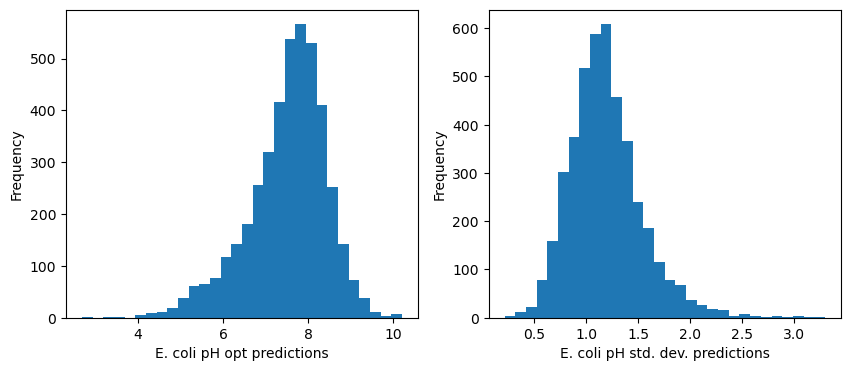

In [30]:
f, (ax, ax2) = plt.subplots(figsize=(10,4), ncols=2)
df_to_pred["esm2_pH_opt"].plot.hist(bins=30, ax=ax)
ax.set_xlabel("E. coli pH opt predictions")
df_to_pred["esm2_pH_std"].plot.hist(bins=30, ax=ax2)
ax2.set_xlabel("E. coli pH std. dev. predictions")

In [31]:
gene_sub = df_to_pred[df_to_pred["Gene Name"].isin(["lldD", "gltA", "ndh", "pyrG"])]
gene_sub[["Gene Name", "esm2_pH_opt", "esm2_pH_std"]]

,Gene Name,esm2_pH_opt,esm2_pH_std
Accession 1,,,
b1109,ndh,7.385746,1.150859
b0720,gltA,7.831304,1.324568
b2780,pyrG,8.136646,0.837240
b3605,lldD,8.808319,1.475052


In [32]:
# define the gaussian function
def gaus(x,c,x_mean,sigma):
    return c*np.exp(-(x-x_mean)**2/(2*sigma**2))

In [33]:
def get_activity_at_ph_gaus(pred_mean, pred_std, ph=7.0):
    """ Get the activity at the given ph value(s) 
    using the predicted pH optimum (mean) and range (standard deviation)
    """
    max_activity = 1
    # if isinstance(int, ph) or isinstance(float, ph):
    return gaus(ph, max_activity, pred_mean, pred_std)

In [34]:
ph_vals = (7.0, 6.5, 6.0, 5.5, 5.0, 4.5)
cols = []
for ph in ph_vals:
    col = f"esm2_act_pH_{ph}"
    cols += [col]
    df_to_pred[col] = df_to_pred.apply(
        lambda row: get_activity_at_ph_gaus(row.esm2_pH_opt, row.esm2_pH_std, ph=ph),
        axis=1,
    )
    

df_to_pred[cols]

,esm2_act_pH_7.0,esm2_act_pH_6.5,esm2_act_pH_6.0,esm2_act_pH_5.5,esm2_act_pH_5.0,esm2_act_pH_4.5
Accession 1,,,,,,
b4154,0.981788,0.968019,0.781795,0.517183,0.280246,0.124388
b1109,0.945375,0.743659,0.484361,0.261210,0.116637,0.043123
b0002,0.780094,0.509121,0.269596,0.115831,0.040379,0.011421
b3940,0.584367,0.323298,0.143919,0.051550,0.014857,0.003446
b3067,0.574096,0.334139,0.162043,0.065478,0.022045,0.006184
...,...,...,...,...,...,...
b1172,0.988651,0.980967,0.862843,0.672784,0.465035,0.284945
b1028,0.834844,0.649900,0.454465,0.285474,0.161082,0.081647
b4504,0.493176,0.279490,0.134134,0.054515,0.018763,0.005469


In [35]:
# colors = sns.color_palette()
colors = sns.color_palette("Spectral")[::-1]

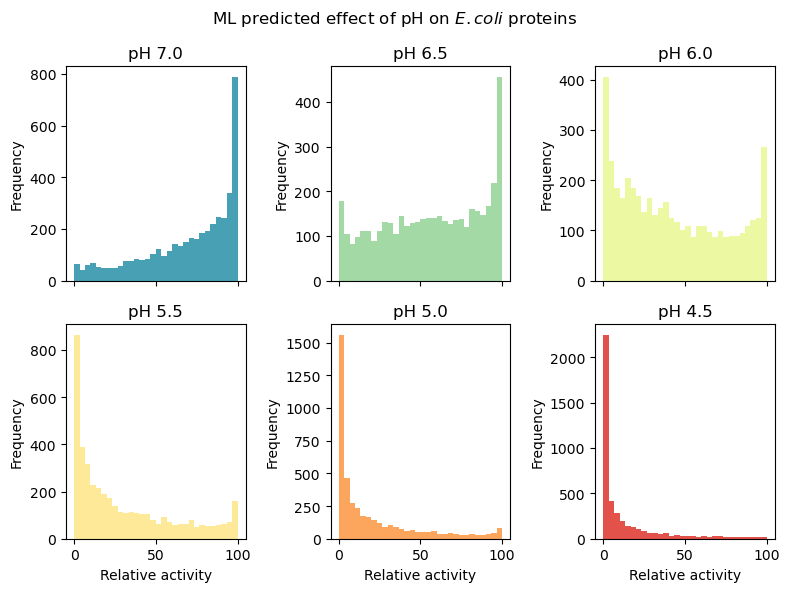

In [41]:
f, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 6), sharex=True)
axes = [ax for ax_list in axes for ax in ax_list]
for i, col in enumerate(cols):
    ax = axes[i]
    (df_to_pred[col] * 100).plot.hist(bins=30, ax=ax,
                              color=colors[i],
                             )
    ax.set_title(f"pH {ph_vals[i]}")
    if i > 2:
        ax.set_xlabel("Relative activity")

plt.suptitle(r"ML predicted effect of pH on $E. coli$ proteins")
plt.tight_layout()

In [64]:
cols

['esm2_act_pH_7.0',
 'esm2_act_pH_6.5',
 'esm2_act_pH_6.0',
 'esm2_act_pH_5.5',
 'esm2_act_pH_5.0',
 'esm2_act_pH_4.5']

In [42]:
df_to_pred[df_to_pred["esm2_act_pH_7.0"] < 0.05]

,Gene Name,UNIPROT,Accession 2,All Names Concat,Left End Position,Right End Position,Centisome Position,Direction,Length (bp),Synonyms,...,sequence difference in MG1655 from W3110 (increased thermotolerance),sequence,esm2_pH_opt,esm2_pH_std,esm2_act_pH_7.0,esm2_act_pH_6.5,esm2_act_pH_6.0,esm2_act_pH_5.5,esm2_act_pH_5.0,esm2_act_pH_4.5
Accession 1,,,,,,,,,,,,,,,,,,,,,
b2315,folC,P08192,ECK2309,folC // b2315 // ECK2309 // dedC // EG10327 //...,2431674,2432942,52.388115,<-,1269,dedC,...,WT,MIIKRTPQAASPLASWLSYLENLHSKTIDLGLERVSLVAARLGVLK...,9.236238,0.886205,4.143020e-02,8.509146e-03,1.271182e-03,1.381282e-04,1.091716e-05,6.276096e-07
b2303,folX,P0AC19,ECK2297,folX // b2303 // ECK2297 // G7195 // ABE-0007603,2421325,2421687,52.165157,->,363,NaN,...,WT,MAQPAAIIRIKNLRLRTFIGIKEEEINNRQDIVINVTIHYPADKAR...,8.877872,0.296899,2.055880e-09,1.178040e-14,3.959251e-21,7.804710e-29,9.023839e-38,6.119511e-48
b4179,rnr,P21499,ECK4175,rnr // b4179 // ECK4175 // vacB // yjeC // EG1...,4406654,4409095,94.937195,->,2442,vacB // yjeC,...,WT,MSQDPFQEREAEKYANPIPSREFILEHLTKREKPASRDELAVELHI...,8.623165,0.629814,3.611609e-02,3.406204e-03,1.710506e-04,4.573649e-06,6.511562e-08,4.936187e-10
b3709,tnaB,P23173,ECK3702,tnaB // b3709 // ECK3702 // tnaP // trpP // EG...,3890236,3891483,83.811455,->,1248,tnaP // trpP,...,"N292K,-293E,-294G,-295A,-296N,-297K,-298R,-299...",MTDQAEKKHSAFWGVMVIAGTVIGGGMFALPVDLAGAWFFWGAFIL...,4.680486,0.577523,3.142244e-04,6.992029e-03,7.352586e-02,3.653848e-01,8.580931e-01,9.523397e-01
b1133,mnmA,P25745,ECK1119,mnmA // b1133 // ECK1119 // asuE // ycfB // tr...,1192667,1193773,25.694883,<-,1107,asuE // ycfB // trmU,...,WT,MSETAKKVIVGMSGGVDSSVSAWLLQQQGYQVEGLFMKNWEEDDGE...,8.528992,0.569569,2.723667e-02,1.755350e-03,5.234703e-05,7.223361e-07,4.612170e-09,1.362668e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b1672,ydhW,P77564,ECK1668,ydhW // b1672 // ECK1668 // G6900 // ABE-0005585,1751077,1751724,37.725296,<-,648,NaN,...,WT,MGKMNHQDELPLAKVSEVDEAKRQWLQGMRHPVDTVTEPEPAEILA...,8.842061,0.395277,1.923834e-05,2.380315e-08,5.945721e-12,2.998318e-16,3.052489e-21,6.273842e-27
b0645,ybeR,P77627,ECK0638,ybeR // b0645 // ECK0638 // G6352 // ABE-0002208,676711,677418,14.579098,->,708,NaN,...,WT,MDMESQKILFALSTPMEIRNECCLPSHSSPKMYLGTCFFDLSSSWG...,3.964513,0.924912,4.582563e-03,2.334348e-02,8.877784e-02,2.520726e-01,5.343533e-01,8.456944e-01
b4506,ykgO,Q2EEQ2,ECK0295,ykgO // b4506 // ECK0295 // G0-10434 // ABE-02...,312374,312514,6.729803,<-,141,NaN,...,x,MKVLNSLRTAKERHPDCQIVKRKGRLYVICKSNPRFKAVQGRKKKR,9.398594,0.922398,3.401306e-02,7.172447e-03,1.127400e-03,1.320925e-04,1.153633e-05,7.510104e-07


Text(0.5, 0.98, 'Proteins with < 5% activity at pH 7 (N=76)')

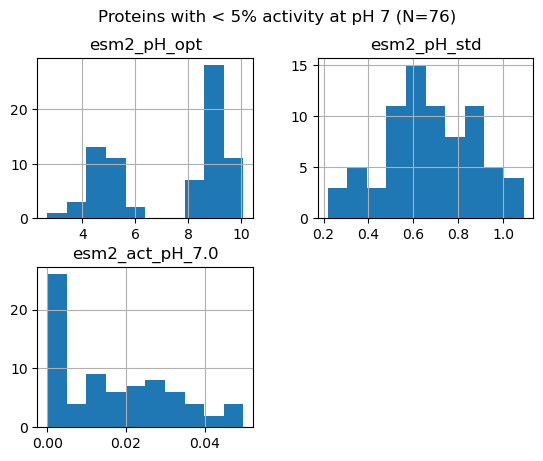

In [44]:
df_to_pred[df_to_pred["esm2_act_pH_7.0"] < 0.05][["esm2_pH_opt", "esm2_pH_std", "esm2_act_pH_7.0"]].hist()
plt.suptitle(f"Proteins with < 5% activity at pH 7 (N={len(df_to_pred[df_to_pred['esm2_act_pH_7.0'] < 0.05])})")

Text(0.5, 1.0, 'Proteins with < 5% activity at pH 7 (N=76)')

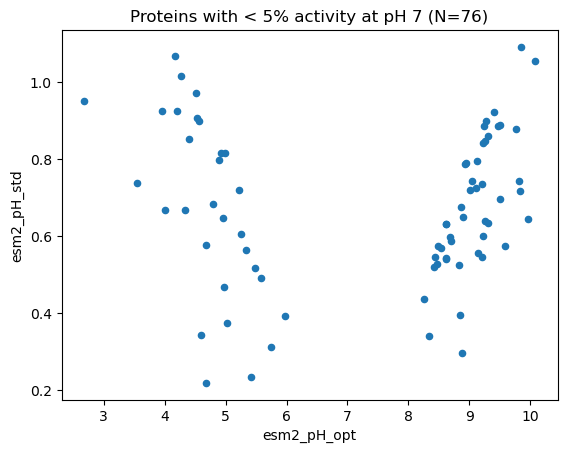

In [46]:
low_act = df_to_pred[df_to_pred["esm2_act_pH_7.0"] < 0.05]
low_act.plot.scatter("esm2_pH_opt", "esm2_pH_std")
plt.title(f"Proteins with < 5% activity at pH 7 (N={len(df_to_pred[df_to_pred['esm2_act_pH_7.0'] < 0.05])})")

In [ ]:
def plot_ph_curve(pred_mean, pred_std, ax=None):
    if ax is None:
        f, ax = plt.subplots(figsize=(3,3))
    # get the predicted activity over all ph values
    all_ph_vals = np.arange(1, 13.5, 0.1)
    pred_act = gaus(all_ph_vals, df2.fit_mean.values[0], df2.fit_std.values[0])
    
    # limit the predicted activity to min_ph -1 and max_ph +1
    df = pd.DataFrame({'ph': all_ph_vals, 'activity': pred_act})
    # df['reaction_type'] = r_type
    # ph_min = min(df_act_u.ph.min() - 1, 5.5)
    # ph_max = max(df_act_u.ph.max() + 1, 8.5)
    ph_min, ph_max = 
    df_pred_act_u_cat = df_pred_act_u_cat[(df_pred_act_u_cat.ph >= ph_min) & 
                                          (df_pred_act_u_cat.ph <= ph_max)]

In [12]:
# seq_idx = {seq: idx for idx, seq in df_seq.sequence.items
seq_idx = dict(zip(df_seq.sequence, df_seq.index))
print(list(seq_idx.items())[:2])

[('MSGEEEKAADFYVRYYVGHKGKFGHEFLEFEFRPNGSLRYANNSNYKNDTMIRKEATVSESVLSELKRIIEDSEIMQEDDDNWPEPDKIGRQELEILYKNEHISFTTGKIGALADVNNSKDPDGLRSFYYLVQDLKCLVFSLIGLHFKIKPI', 0), ('MSMGSDFYLRYYVGHKGKFGHEFLEFEFRPDGKLRYANNSNYKNDVMIRKEAYVHKSVMEELKRIIDDSEITKEDDALWPPPDRVGRQELEIVIGDEHISFTTSKIGSLIDVNQSKDPEGLRVFYYLVQDLKCLVFSLIGLHFKIKPI', 1)]
